C:\Users\vigne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


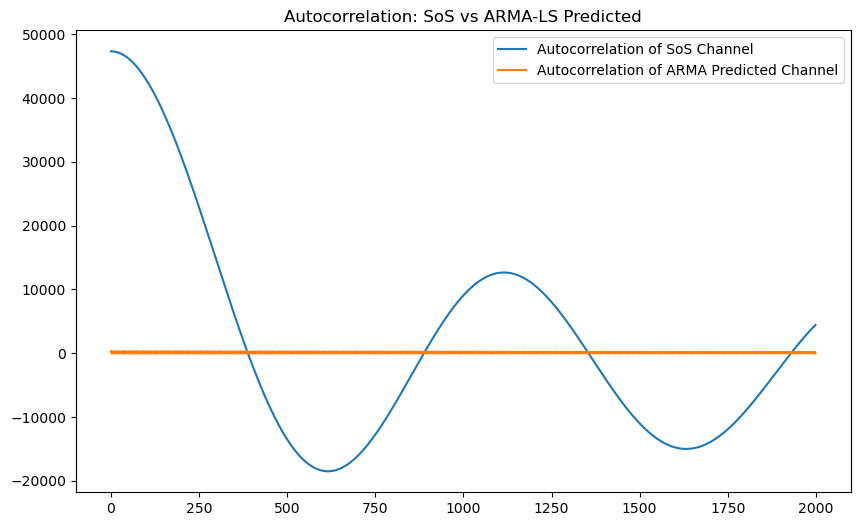

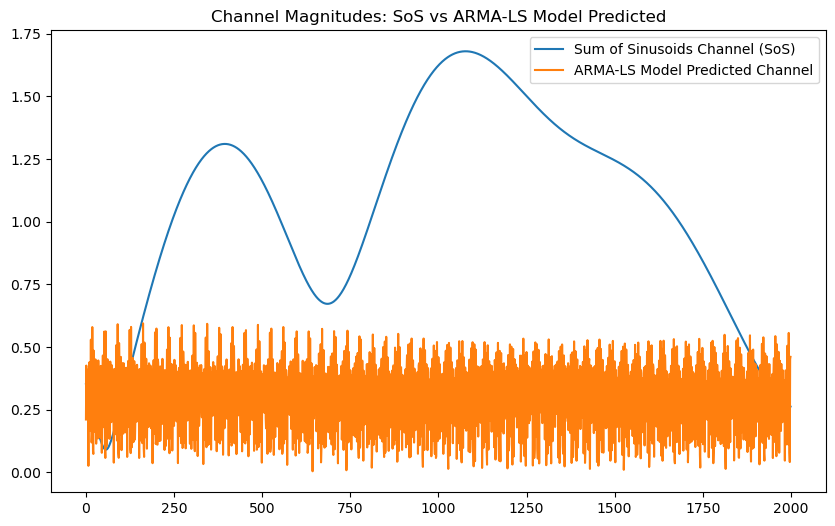

In [8]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import math

# Signal and channel parameters
Fs = 100000  # Sampling frequency
Fc = 2e9     # Carrier frequency
Fd = 100*(100 / Fs)  # Doppler frequency = 100
Tc = 1 / (10 * Fd)  # Coherence time based on Doppler frequency
N = 100000  # Number of data points in the signal
M = 3  # Number of different channel values (multi-path)
packet_size = math.floor(Fs * Tc) // 5  # Size of each packet
header_packet_size = math.floor((1 / 6) * packet_size)  # Known part of the signal (header)
noise_SNR = 10
noise_level = 1 / noise_SNR  # Noise level (1/SNR)
snr_db = 10  # SNR in dB

# Function to generate Jakes random variables (SoS model)
def jakes_sos(P, K, Fs, Fd, num_sinusoids, typ):
    t = np.linspace(0, P / Fs, P)
    omega_d = 2 * np.pi * Fd
    jakes_rvs = np.zeros((K, P), dtype=complex)
    
    for k in range(K):
        alpha = np.random.uniform(0, 2 * np.pi, num_sinusoids)
        alpha_m = np.array([((2 * np.pi * n) - np.pi + al)/(4 * num_sinusoids) for n, al in enumerate(alpha)])
        a_m = np.random.uniform(0, 2 * np.pi, num_sinusoids)
        b_m = np.random.uniform(0, 2 * np.pi, num_sinusoids)
        
        cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
        real_part = np.sqrt(1 / num_sinusoids) * np.sum(cosine_terms, axis=1)
        
        if typ == 'comp':
            sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
            imag_part = np.sqrt(1 / num_sinusoids) * np.sum(sine_terms, axis=1)
            jakes_rvs[k] = real_part + 1j * imag_part
        else:
            jakes_rvs[k] = real_part + 1j * 0  # Treat as complex for uniformity
    
    return jakes_rvs

# Generate BPSK signal
def generate_bpsk_signal(num_samples):
    bits = np.random.randint(0, 2, num_samples)
    return 2 * bits - 1  # BPSK: 0 -> -1, 1 -> 1

# Add noise to the signal based on SNR
def add_noise(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

# Function to calculate autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

# Function to fit ARMA models to the real and imaginary parts of the channel
def fit_arma_model(channel_data, ar_order, ma_order):
    # Fit ARMA model for real part
    real_arma_model = ARIMA(np.real(channel_data), order=(ar_order, 0, ma_order)).fit()
    imag_arma_model = ARIMA(np.imag(channel_data), order=(ar_order, 0, ma_order)).fit()
    return real_arma_model, imag_arma_model

# Function to predict channel values using ARMA models
def predict_arma_channel(real_arma_model, imag_arma_model, steps):
    real_pred = real_arma_model.predict(start=len(real_arma_model.data.endog), end=len(real_arma_model.data.endog) + steps - 1)
    imag_pred = imag_arma_model.predict(start=len(imag_arma_model.data.endog), end=len(imag_arma_model.data.endog) + steps - 1)
    
    predicted_channel = real_pred + 1j * imag_pred
    return predicted_channel

# Main function for adaptive model (LS + ARMA)
def main():
    P = N  # Number of samples in the channel (same as the global N)
    Fd = 100  # Doppler spread (Hz)
    num_sinusoids = 100  # Number of sinusoids
    K = 1  # Single random process
    typ = 'comp'
    ar_order = 5  # AR order
    ma_order = 2  # MA order
    steps = 5000  # Future steps to predict using ARMA

    # Generate Jakes channel (sum-of-sinusoids)
    jakes_rvs = jakes_sos(P, K, Fs, Fd, num_sinusoids, typ).flatten()

    # Generate BPSK signal
    signal = generate_bpsk_signal(P)

    # Transmit signal through channel
    transmitted_signal = signal * jakes_rvs

    # Add noise
    noisy_signal = add_noise(transmitted_signal, snr_db)

    # Initialize lists to store the LS estimates
    channel_estimates = []

    # Process packets for LS estimation and ARMA
    for packet_start in range(0, P, packet_size):
        packet_end = min(packet_start + packet_size, P)
        
        # Known header part of the packet
        header_signal = signal[packet_start:packet_start + header_packet_size]
        header_noisy_signal = noisy_signal[packet_start:packet_start + header_packet_size]

        # Estimate the channel for the header using LS
        channel_estimated, _, _, _ = lstsq(header_signal.reshape(-1, 1), header_noisy_signal)
        channel_estimated = channel_estimated[0]  # Get the estimated channel value

        # Predict the rest of the packet using the estimated channel
        rest_signal = signal[packet_start + header_packet_size:packet_end]
        predicted_noisy_signal = rest_signal * channel_estimated
        
        # Store channel estimates
        channel_estimates.append(channel_estimated)
        
        # Continue predicting for next packet using the ARMA model
        if len(channel_estimates) >= ar_order:
            # Fit ARMA model to the estimated channels
            real_arma_model, imag_arma_model = fit_arma_model(channel_estimates, ar_order, ma_order)
            predicted_arma_channel = predict_arma_channel(real_arma_model, imag_arma_model, steps)
            
            # Replace channel_estimated with predicted ARMA channel for next packets
            channel_estimated = predicted_arma_channel[0]  # Use first predicted value for next packet

    # Combine the LS estimates and ARMA predicted values for full signal
    full_channel_predicted = np.concatenate([channel_estimates, predicted_arma_channel])

    # Autocorrelation comparison
    autocorr_sos = autocorr(np.real(jakes_rvs))
    autocorr_predicted = autocorr(np.real(full_channel_predicted))

    # 1. Plot Autocorrelation of SoS channel and ARMA-predicted channel
    plt.figure(figsize=(10, 6))
    plt.plot(autocorr_sos[0:2000], label='Autocorrelation of SoS Channel')
    plt.plot(autocorr_predicted[0:2000], label='Autocorrelation of ARMA Predicted Channel')
    plt.legend()
    plt.title('Autocorrelation: SoS vs ARMA-LS Predicted')
    plt.show()

    # 2. Plot channel magnitudes (SoS vs ARMA-LS predicted)
    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(jakes_rvs)[0:2000], label='Sum of Sinusoids Channel (SoS)')
    plt.plot(np.abs(full_channel_predicted)[0:2000], label='ARMA-LS Model Predicted Channel')
    plt.legend()
    plt.title('Channel Magnitudes: SoS vs ARMA-LS Model Predicted')
    plt.show()

if __name__ == "__main__":
    main()
